In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

# Reading Data from Files

In [2]:
fileprefix = "pilot_2" # pilot_[1,2]
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [3]:
# Testing getting expected score of one trial

with open(all_part_paths[1], 'r') as f:
    participant = json.load(f)

for idx, trial in enumerate(participant['data']):
    trial_type = trial['trialdata']['trial_type']
    try:
        trial_id = str(trial['trialdata']['trial_id'])
    except KeyError:
        trial_id = ""
        
    if trial_type == "mouselab-mdp" and not trial_id.startswith("practice"):
        selected_trial = trial
        break

g_truth = [0.0] + selected_trial['trialdata']['stateRewards'][1:]
mEnv = MouselabEnv.new_symmetric_registered('high_increasing', ground_truth=g_truth)
clicks = selected_trial['trialdata']['queries']['click']['state']['target']
clicks = [int(click) for click in clicks]
for click in clicks:
    mEnv.step(clicks[0])
mEnv._state
# mEnv._term_reward()

(0, -2.0, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat)

# Analyzing Trial Data

In [4]:
part_stats_dicts = []
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    rewardsWithheld = []
    effort = "-1"
    
    firstTrialStamp = participant['data'][0]['dateTime']
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    stroop_timestamps = {
        "1" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        },
        "2" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        }
    }
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    stroop1Completed = 0
    stroop1Correct = 0
    stroop2Completed = 0
    stroop2Correct = 0
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
#         if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
#             print("{}\t{}\t{}".format(trial_type, trial_id, idx))
        if trial_id == "stroop_1_ready_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["start"] = trial['dateTime']
            
        if trial_id == "stroop_2_ready_1" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["start"] = trial['dateTime']
            
        if trial_id == "finish_distractor_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["end"] = trial['dateTime']
            stroop_timestamps["1"]["done"] = True
            
        if trial_id == "finish_distractor_2" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["end"] = trial['dateTime']
            stroop_timestamps["2"]["done"] = True
            
        if trial_id == "mouselab_instructions_1" and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        if "congruent" in trial_id or "incongruent" in trial_id or "unrelated" in trial_id:
            if not stroop_timestamps["1"]["done"]:
                stroop1Completed += 1
                
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop1Correct += 1
                
            else:
                stroop2Completed += 1
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop2Correct += 1
                    
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('high_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                for click in clicks:
                    mEnv.step(int(click))
                
                expectedScores.append(mEnv._term_reward() + trial['trialdata']['costs'])
                
        if trial_type == 'survey-html-form':
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
        if trial_type == 'survey-text':
            feedback = trial['trialdata']['response']['Q0']
            comments = trial['trialdata']['response']['Q2']
        last_trial = trial

    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps, stroop_timestamps["1"], stroop_timestamps["2"]], ["mdp", "s1", "s2"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
            
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "stroop1Length" : (stroop_timestamps["1"]["end"] - stroop_timestamps["1"]["start"]) / 1000,
        "stroop2Length" : (stroop_timestamps["2"]["end"] - stroop_timestamps["2"]["start"]) / 1000,
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "stroop1Completed" : stroop1Completed,
        "stroop2Completed" : stroop2Completed,
        "stroop1Correct" : stroop1Correct,
        "stroop2Correct" : stroop2Correct,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["stroop1Length"] + part_stats_dict["mouselabLength"] + part_stats_dict["stroop2Length"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

In [66]:
# Compiling all data into trial data

all_trial_data = {
    "trialScores": [],
    "expectedScores": [],
    "trialNumbers": [],
    "scarce": [],
    "numRewardedTrials": [],
    "numUnrewardedTrials": [],
    "workerId": [],
    "rewardsWithheld" : []
}

for part in part_stats_dicts:
    if len(part['trialScores']) not in [30, 120]:
        continue
    all_trial_data['trialScores'] += part['trialScores']
    all_trial_data['rewardsWithheld'] += part['rewardsWithheld']
    all_trial_data['workerId'] += [part['workerId']] * len(part['trialScores'])
    all_trial_data['expectedScores'] += part['expectedScores']
    all_trial_data['trialNumbers'] += list(range(1,len(part['trialScores'])+1))
    all_trial_data['scarce'] += [int(len(part['trialScores']) == 120)] * len(part['trialScores'])
    all_trial_data['numRewardedTrials'] += [i - sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]
    all_trial_data['numUnrewardedTrials'] += [sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]

all_trials_df = pd.DataFrame(all_trial_data)


In [67]:
all_trials_df

,trialScores,expectedScores,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld
0,38.0,9.0,1,0,0,0,6140be2fdc5e6f433f412f7a,False
1,30.0,1.0,2,0,1,0,6140be2fdc5e6f433f412f7a,False
2,30.0,25.0,3,0,2,0,6140be2fdc5e6f433f412f7a,False
3,25.0,20.0,4,0,3,0,6140be2fdc5e6f433f412f7a,False
4,52.0,-1.0,5,0,4,0,6140be2fdc5e6f433f412f7a,False
...,...,...,...,...,...,...,...,...
2935,40.0,35.0,26,0,25,0,6130ceb2390f7cb3284f33a9,False
2936,31.0,26.0,27,0,26,0,6130ceb2390f7cb3284f33a9,False
2937,26.0,21.0,28,0,27,0,6130ceb2390f7cb3284f33a9,False
2938,58.0,53.0,29,0,28,0,6130ceb2390f7cb3284f33a9,False


In [104]:
included

,trialScores,expectedScores,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld
0,56.25,47.25,120,1,30,89,612288702a5316519e4e9602,True
1,46.75,47.75,120,1,30,89,5f5a69a0b2b7c2119ecf07bf,True
2,-7.75,23.25,120,1,30,89,614775c6f329a9e5ab190e04,True
3,32.25,27.25,120,1,30,89,60b240b5ea9091ab2f12568b,True
4,54.50,47.50,120,1,30,89,60d4c52faeecc354694c9fe7,True
5,48.75,47.75,120,1,30,89,61093d97f7bf8a4f8117eb82,True
6,60.75,47.75,120,1,30,89,5ec6583644972a0315eb4f0d,True
7,34.50,23.50,120,1,30,89,609337515bc9469811c3486c,True
8,42.75,47.75,120,1,29,90,6141210c31f06c30f5f58104,False
9,22.50,23.50,120,1,30,89,5f1f5551a6dae413877f49c7,True


In [123]:
# Removing outliers 

# For each participant?

outliers_excluded_part = pd.DataFrame(columns=all_trials_df.columns)
for worker in np.unique(all_trials_df.workerId):
    workerRows = all_trials_df.loc[all_trials_df.workerId == worker].reset_index(drop=True)
    included = workerRows[(np.abs(scipy.stats.zscore(workerRows.expectedScores)) < 3)]
    outliers_excluded_part = pd.concat([outliers_excluded_part,included], ignore_index=True)

outliers_excluded_part['trialNumbers'] = outliers_excluded_part['trialNumbers'].astype('int64')
outliers_excluded_part['scarce'] = outliers_excluded_part['scarce'].astype('int64')
outliers_excluded_part['numRewardedTrials'] = outliers_excluded_part['numRewardedTrials'].astype('int64')
outliers_excluded_part['numUnrewardedTrials'] = outliers_excluded_part['numUnrewardedTrials'].astype('int64')

# For each trial?

outliers_excluded_trial = pd.DataFrame(columns=all_trials_df.columns)
for trial in np.unique(all_trials_df.trialNumbers):
    trialRowsScarce = all_trials_df.loc[(all_trials_df.trialNumbers == trial) & (all_trials_df.scarce == 1)].reset_index(drop=True)
    included = trialRowsScarce[(np.abs(scipy.stats.zscore(trialRowsScarce.expectedScores)) < 3)]
    outliers_excluded_trial = pd.concat([outliers_excluded_trial,included], ignore_index=True)
    
    if trial <= 30:
        trialRowsControl = all_trials_df.loc[(all_trials_df.trialNumbers == trial) & (all_trials_df.scarce == 0)].reset_index(drop=True)
        included = trialRowsControl[(np.abs(scipy.stats.zscore(trialRowsControl.expectedScores)) < 3)]
        outliers_excluded_trial = pd.concat([outliers_excluded_trial,included], ignore_index=True)

outliers_excluded_trial['trialNumbers'] = outliers_excluded_trial['trialNumbers'].astype('int64')
outliers_excluded_trial['scarce'] = outliers_excluded_trial['scarce'].astype('int64')
outliers_excluded_trial['numRewardedTrials'] = outliers_excluded_trial['numRewardedTrials'].astype('int64')
outliers_excluded_trial['numUnrewardedTrials'] = outliers_excluded_trial['numUnrewardedTrials'].astype('int64')

# Overall?

outliers_excluded = all_trials_df[(np.abs(scipy.stats.zscore(all_trials_df.expectedScores)) < 3)]

outliers_excluded_trial

,trialScores,expectedScores,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld
0,63.75,58.75,1,1,0,0,612288702a5316519e4e9602,True
1,38.50,1.50,1,1,0,0,5f5a69a0b2b7c2119ecf07bf,False
2,60.75,-0.25,1,1,0,0,614775c6f329a9e5ab190e04,False
3,-7.75,3.25,1,1,0,0,60b240b5ea9091ab2f12568b,True
4,27.25,22.25,1,1,0,0,60d4c52faeecc354694c9fe7,True
...,...,...,...,...,...,...,...,...
2924,57.75,50.75,120,1,30,89,5f63c23441886d11737a8c4f,True
2925,47.00,42.00,120,1,30,89,615325dde7a4d7a78fa314b5,True
2926,42.50,47.50,120,1,30,89,612f3f73f0f8086722abf5c5,True
2927,46.75,47.75,120,1,30,89,60abf71aa3abebc8ba3c5b67,True


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_87649/3220700914.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))


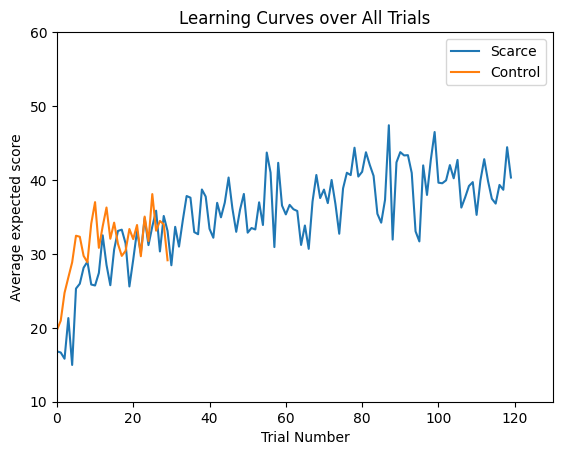

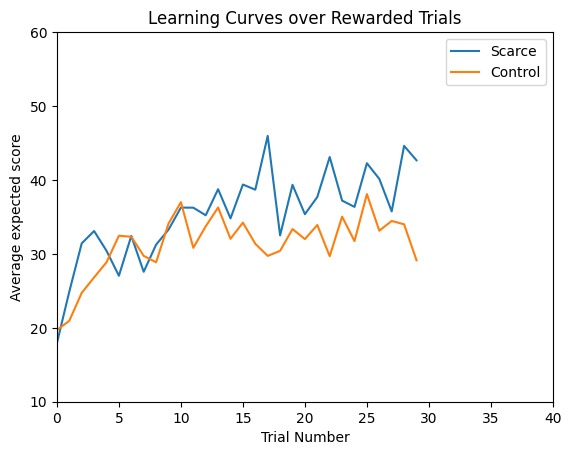

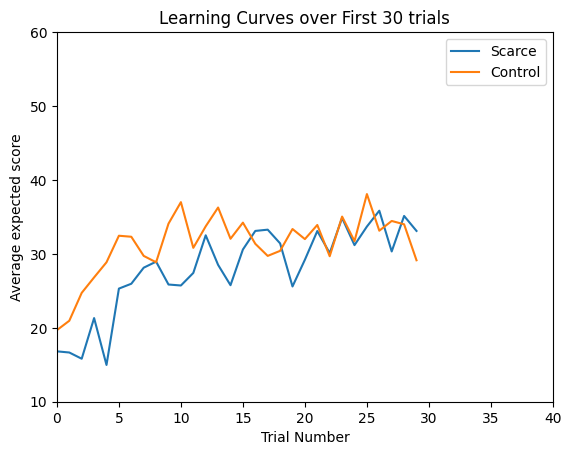

In [112]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = outliers_excluded_trial.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# Taking the mean expected score over all trials 
scarce_data_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["expectedScores"])
control_data = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["expectedScores"])
scarce_data_first_30 = scarce_data_all[0:30]

# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["expectedScores"])

plt.figure()
plt.title("Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()

plt.figure()
plt.title("Learning Curves over First 30 trials")
plt.plot(list(range(len(scarce_data_first_30))), scarce_data_first_30, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()



In [118]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

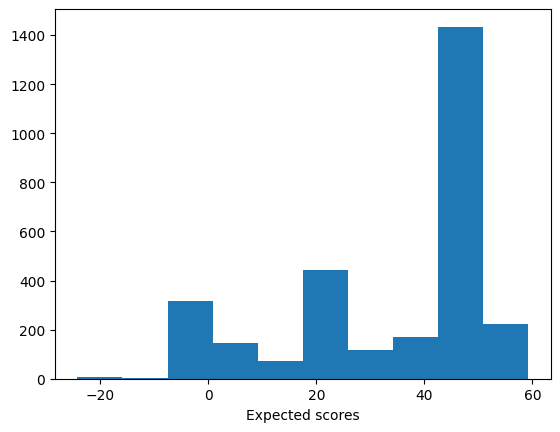

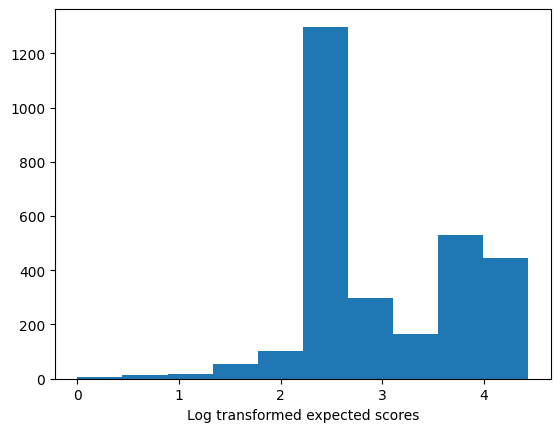

In [121]:
# Transforming the data

data_to_copy = outliers_excluded_trial.copy() # or outliers_excluded


transformed_trials_df = data_to_copy.copy()
log_transformed_trials_df = data_to_copy.copy()
sq_transformed_trials_df = data_to_copy.copy()
cb_transformed_trials_df = data_to_copy.copy()
arcsin_transformed_trials_df = data_to_copy.copy()

plt.figure()
plt.hist(transformed_trials_df['expectedScores'])
plt.xlabel('Expected scores')
log_transformed_trials_df['expectedScores'] = np.log(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
sq_transformed_trials_df['expectedScores'] = np.sqrt(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
cb_transformed_trials_df['expectedScores'] = np.cbrt(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
arcsin_transformed_trials_df['expectedScores'] = np.sqrt(np.arcsin(scale_to_range(transformed_trials_df['expectedScores'], -1, 1)))

plt.figure()
plt.hist(log_transformed_trials_df['expectedScores'])
plt.xlabel("Log transformed expected scores")
plt.show()

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expectedScores
No. Observations:     2929       Method:                REML          
No. Groups:           41         Scale:                 0.3658        
Min. group size:      30         Log-Likelihood:        -2760.4462    
Max. group size:      120        Converged:             Yes           
Mean group size:      71.4                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    3.274    0.093 35.244 0.000  3.092  3.456
C(scarce)[T.1]              -0.057    0.129 -0.442 0.659 -0.309  0.195
trialNumbers                -0.008    0.003 -3.014 0.003 -0.014 -0.003
trialNumbers:C(scarce)[T.1]  0.004    0.003  1.477 0.140 -0.001  0.009
Group Var              

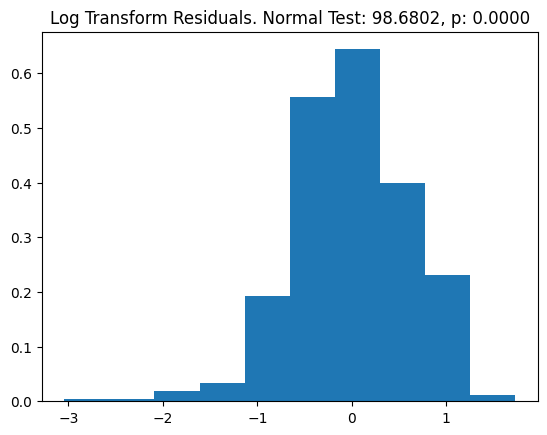

In [127]:
# GLM Model 1 - Expected score vs. Trial number & Condition - log transform

formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=log_transformed_trials_df, groups=log_transformed_trials_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=log_transformed_trials_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Log Transform Residuals. Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expectedScores
No. Observations:     2929       Method:                REML          
No. Groups:           41         Scale:                 1.9242        
Min. group size:      30         Log-Likelihood:        -5194.6271    
Max. group size:      120        Converged:             Yes           
Mean group size:      71.4                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    5.470    0.242 22.628 0.000  4.996  5.944
C(scarce)[T.1]              -0.080    0.340 -0.236 0.814 -0.746  0.586
trialNumbers                -0.023    0.006 -3.756 0.000 -0.036 -0.011
trialNumbers:C(scarce)[T.1]  0.012    0.006  1.907 0.057 -0.000  0.024
Group Var              

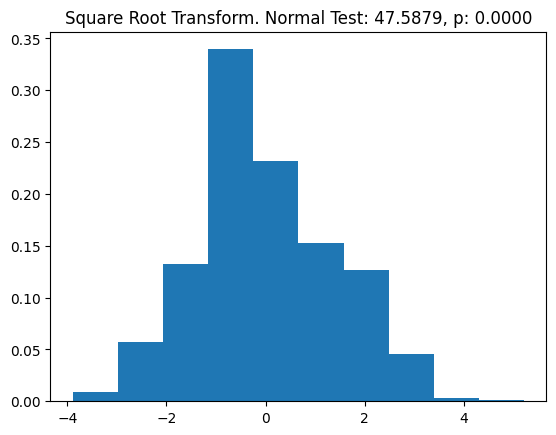

In [115]:
# GLM Model 1 - Expected score vs. Trial number & Condition - square root transform

formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=sq_transformed_trials_df, groups=sq_transformed_trials_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=sq_transformed_trials_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Square Root Transform. Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expectedScores
No. Observations:     2929       Method:                REML          
No. Groups:           41         Scale:                 0.3003        
Min. group size:      30         Log-Likelihood:        -2476.0924    
Max. group size:      120        Converged:             Yes           
Mean group size:      71.4                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    3.064    0.092 33.307 0.000  2.884  3.245
C(scarce)[T.1]              -0.038    0.129 -0.299 0.765 -0.291  0.214
trialNumbers                -0.009    0.002 -3.546 0.000 -0.014 -0.004
trialNumbers:C(scarce)[T.1]  0.004    0.002  1.786 0.074 -0.000  0.009
Group Var              

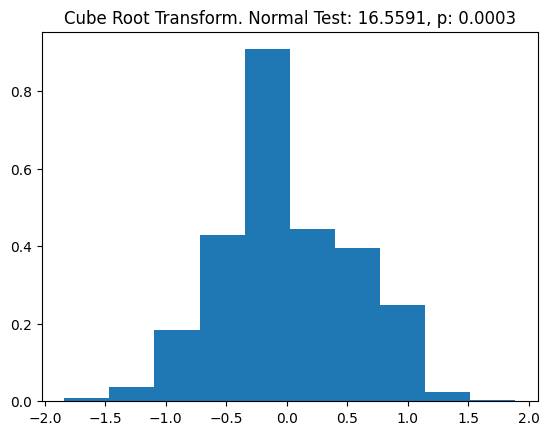

In [116]:
# GLM Model 1 - Expected score vs. Trial number & Condition - cube root transform

formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=cb_transformed_trials_df, groups=cb_transformed_trials_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=cb_transformed_trials_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Cube Root Transform. Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [122]:
# GLM Model 1 - Expected score vs. Trial number & Condition - sqrt arcsin transform

formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=arcsin_transformed_trials_df, groups=arcsin_transformed_trials_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=arcsin_transformed_trials_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Arcsin Transform. Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

IndexError: index 2392 is out of bounds for axis 0 with size 2386

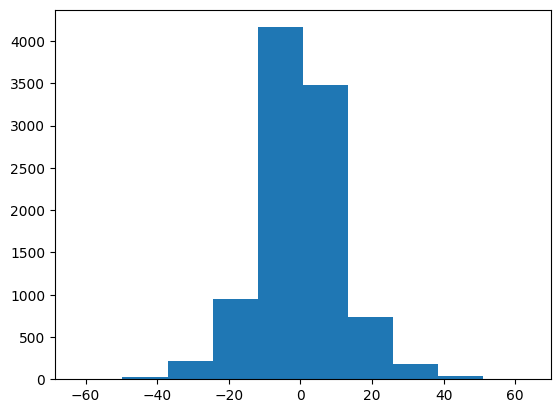

NormaltestResult(statistic=520.5287178867579, pvalue=9.30304399544072e-114)

In [137]:
data = []
for scale in np.arange(0.5, 20, 0.20):
    data += list(scipy.stats.norm.rvs(scale=scale, size=100))

plt.hist(data)
plt.show()

scipy.stats.normaltest(data)

             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  expectedScores
No. Observations:  2929     Method:              REML          
No. Groups:        41       Scale:               203.5281      
Min. group size:   30       Log-Likelihood:      -12018.1224   
Max. group size:   120      Converged:           Yes           
Mean group size:   71.4                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            27.263    1.893 14.403 0.000 23.553 30.973
numRewardedTrials     0.292    0.058  5.078 0.000  0.179  0.405
numUnrewardedTrials   0.075    0.022  3.417 0.001  0.032  0.119
Group Var           131.621    2.158                           



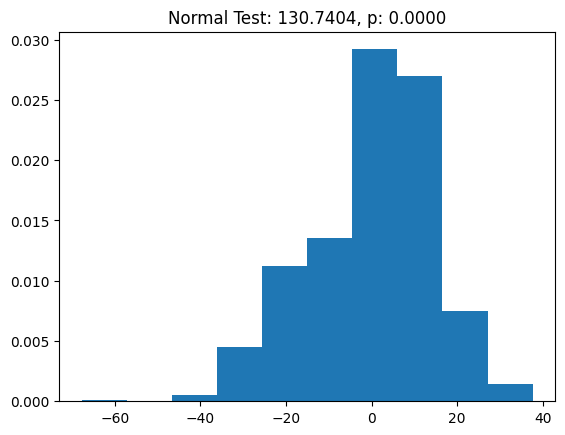

In [135]:
# GLM 2 - Expected score vs num rewarded trials (within group)

scarce_df = transformed_trials_df.loc[transformed_trials_df.scarce == 1]

formula = 'expectedScores ~ numRewardedTrials + numUnrewardedTrials'

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=transformed_trials_df, groups=transformed_trials_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=transformed_trials_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [64]:
# GLM 3 - finding cut off point of learning phase

# For scarce trials
scarce_trials = all_trials_df.loc[all_trials_df.scarce == 1]
for trialNum in range(2,30):
    partition_1_df = scarce_trials.loc[scarce_trials.trialNumbers <= trialNum]
    partition_2_df = scarce_trials.loc[scarce_trials.trialNumbers > trialNum]
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
    glm_1 = smf.glm(formula=formula, data=partition_1_df)
    glm_2 = smf.glm(formula=formula, data=partition_2_df)

    results_1 = glm_1.fit()
    results_2 = glm_2.fit()
    
    z1 = (results_1.params['trialNumbers'] / results_1.bse['trialNumbers'])
    z2 = (results_2.params['trialNumbers'] / results_2.bse['trialNumbers'])
    print(results_1.summary())
    break;
    zscore = np.abs(z1-z2)
    pvalue = 2 * scipy.stats.norm.cdf(-zscore)
    if(pvalue < 0.05): print(trialNum)
    
# For non scarce trials
nonscarce_trials = all_trials_df.loc[all_trials_df.scarce == 0]
for trialNum in range(2,30):
    partition_1_df = nonscarce_trials.loc[nonscarce_trials.trialNumbers <= trialNum]
    partition_2_df = nonscarce_trials.loc[nonscarce_trials.trialNumbers > trialNum]
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

    glm_1 = smf.glm(formula=formula, data=partition_1_df)
    glm_2 = smf.glm(formula=formula, data=partition_2_df)

    results_1 = glm_1.fit()
    results_2 = glm_2.fit()
    
    z1 = (results_1.params['trialNumbers'] / results_1.bse['trialNumbers'])
    z2 = (results_2.params['trialNumbers'] / results_2.bse['trialNumbers'])
    zscore = np.abs(z1-z2)
    pvalue = 2 * scipy.stats.norm.cdf(-zscore)
    if(pvalue < 0.05): print(trialNum)
    

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                   38
Model:                            GLM   Df Residuals:                       36
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          399.66
Method:                          IRLS   Log-Likelihood:                -166.71
Date:                Fri, 02 Sep 2022   Deviance:                       14388.
Time:                        16:41:55   Pearson chi2:                 1.44e+04
No. Iterations:                     3   Pseudo R-squ. (CS):           0.001450
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       16.9737     10.255      1.655   